In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
library(ggrepel)
library(tidyr)
set.seed(42)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# function to load xlsx with multiple sheets
multiplesheets <- function(fname) {
   
  # getting info about all excel sheets
  sheets <- readxl::excel_sheets(fname)
  tibble <- lapply(sheets, function(x) readxl::read_excel(fname, sheet = x))
  data_frame <- lapply(tibble, as.data.frame)
    
  # assigning names to data frames
  names(data_frame) <- sheets
    
  data_frame
}

In [3]:
# function to construct a volcano plot from a df with pvals, avg_log2FC, and gene/TF names
volcanoplot <- function(df,
                        title,
                        label_genes,
                        pval_colname = 'fdr',
                        FC_colname = 'coef',
                        label_colname = 'primerid',
                        ep = 1e-400,
                        p_cutoff = 0.05,
                        FC_cutoff = c(-1, 1),
                        max_overlaps = 20,
                        label_uplim = c(2,4),
                        label_downlim = c(-2,-4),
                        xlabel = 'Coef',
                        ylabel = '-log(FDR)') {
   
  # calculate -log10 pval (add epsilon to account for 0s)
  #ep <- min(df[[pval_colname]][df[[pval_colname]] != 0])
  df$log10_pval <- -log10(df[[pval_colname]] + ep) 
  
  # add column for points above or below FC cutoffs
  df$Key <- 'NOT SIGNIFICANT'
  df$Key[df[[FC_colname]] > FC_cutoff[2] & df[[pval_colname]] < p_cutoff] <- 'UP'
  df$Key[df[[FC_colname]] < FC_cutoff[1] & df[[pval_colname]] < p_cutoff] <- 'DOWN'
  
  # add label column: label the `label_n' most extreme values
  df$to_label <- FALSE
  df <- df %>% mutate(to_label = ifelse(.data[[label_colname]] %in% label_genes, TRUE, FALSE))
  
  df$label_name <- df[[label_colname]]
  df$label_name <- sub("_.*", "", df$label_name)
  df$label_name[!df$to_label] <- NA

  #plot
  ggplot(data=df, aes(x=.data[[FC_colname]], y=log10_pval, col=Key, label = label_name, alpha = Key)) +
    geom_point() +
    theme_bw() +
    theme(
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_blank()
        ) +
    geom_text_repel(data = subset(df, df$Key == 'UP'),
                    max.overlaps = max_overlaps, 
                    xlim = label_uplim,
                    colour = 'black',
                    hjust = 0,
                    size = 4,
                    force = 0.5,
                    direction="y",
                    segment.size = 0.2) +
    geom_text_repel(data = subset(df, df$Key == 'DOWN'),
                    max.overlaps = max_overlaps, 
                    xlim = label_downlim,
                    colour = 'black',
                    hjust = 0,
                    size = 4,
                    force = 0.5,
                    direction="y",
                    segment.size = 0.2) +
    geom_hline(yintercept=-log10(p_cutoff + ep), linetype = 2) +
    ggtitle(title) +
    xlab(xlabel) +
    ylab(ylabel) +
    theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
  )+
    scale_color_manual(values=c('#7f7f7f', 'lightgrey', '#F8766D')) +
    scale_alpha_manual(values = c(UP = 1, DOWN = 1, `NOT SIGNIFICANT` = 0.4))+
    guides(color = "none", alpha = "none")
}

In [4]:
diffchromvar_save_path <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/results/DGE/chromvar_Bladder/Neutrophils_diffchromvar_res.xlsx'
diffchromvar <- multiplesheets(diffchromvar_save_path)

Warning message in annotate("text", x = -0.65, y = 15.25, label = "PBS", size = 5, :
“Ignoring unknown parameters: `face`”
Warning message in annotate("text", x = 1, y = 15.25, label = "BCG+BG", size = 5, :
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 70 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 110 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


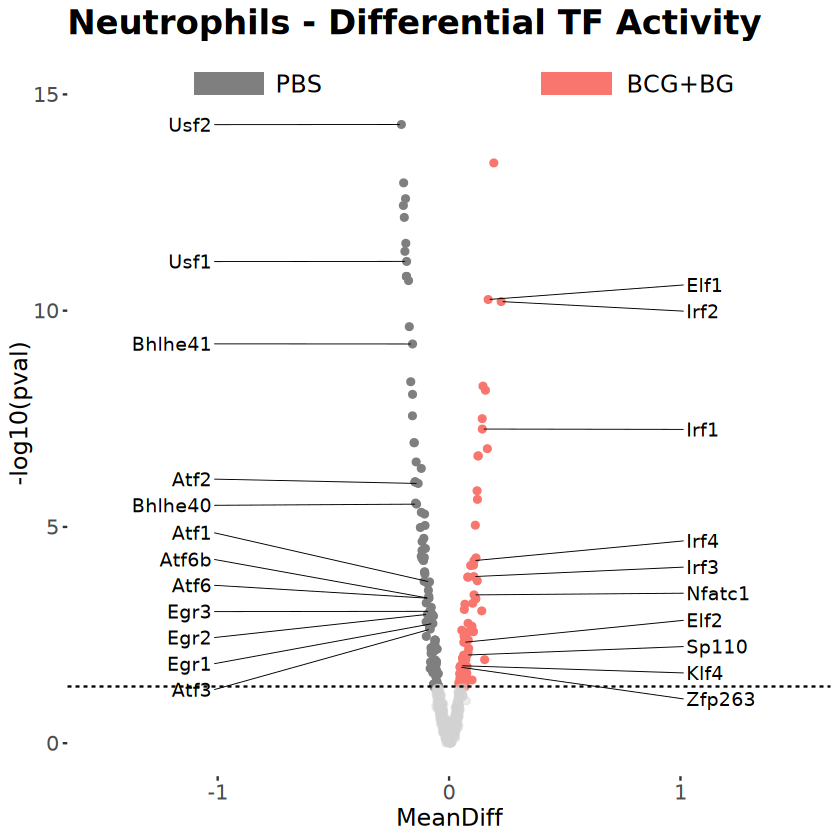

In [8]:
df <- diffchromvar[['PBS_VS_B-Glucan-BCG-after']]

genes_to_label <- c('Elf1_285','Elf2_286','Irf1_631','Irf2_636','Irf3_630','Irf4_632',
           'Nfatc1_703','Sp110_718','Klf4_143','Zfp263_878', 
           'Usf1_46','Usf2_95', 'Bhlhe41_56', 'Bhlhe40_55', 'Egr1_190', 'Egr2_188', 'Egr3_183',
           'Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100')

p1 <- volcanoplot(df,
            'Neutrophils - Differential TF Activity',
            genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5) +
            annotation_custom(grob = grid::rectGrob(gp = grid::gpar(fill = "#7f7f7f", col = NA)), 
                      xmin = -1.1, xmax = -0.8, ymin = 15, ymax = 15.5) +
            annotation_custom(grob = grid::rectGrob(gp = grid::gpar(fill = "#F8766D", col = NA)), 
                      xmin = 0.4, xmax = 0.7, ymin = 15, ymax = 15.5) +
            annotate("text", x = -0.65, y = 15.25, label = "PBS", size = 5, hjust = 0.5, face = "bold") +
            annotate("text", x = 1, y = 15.25, label = "BCG+BG", size = 5, hjust = 0.5, face = "bold")
  
p1

Warning message in annotate("text", x = -0.55, y = 16.55, label = "PBS", size = 5, :
“Ignoring unknown parameters: `face`”
Warning message in annotate("text", x = 1, y = 16.55, label = "BCG+BG", size = 5, :
“Ignoring unknown parameters: `face`”
Warning message:
“Removed 45 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 110 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


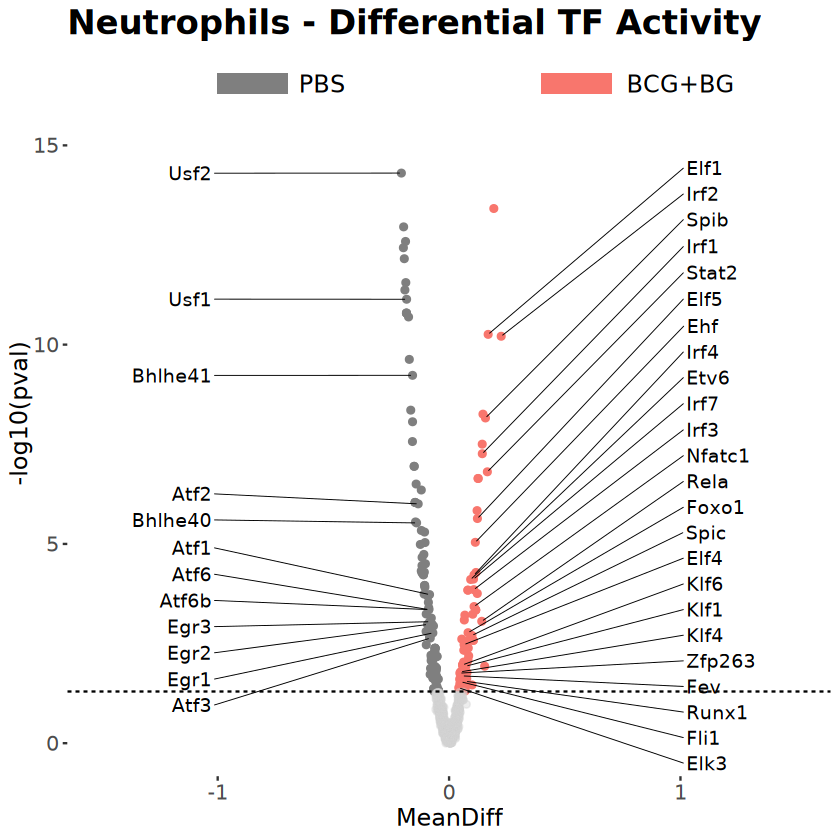

In [7]:
df <- diffchromvar[['PBS_VS_B-Glucan-BCG-after']]

genes_to_label <- unique(c('Elf1_285','Elf2_286','Irf1_631','Irf2_636','Irf3_630','Irf4_632','Nfatc1_703','Sp110_718',
           'Klf4_143','Zfp263_878','Usf1_46','Usf2_95','Bhlhe41_56','Bhlhe40_55','Egr1_190','Egr2_188', 
           'Egr3_183','Atf1_106', 'Atf2_112', 'Atf3_110' , 'Atf6_111', 'Atf6b_100','Spib_271','Elf5_281',
           'Ehf_275','Etv6_282','Spic_269','Etv2_270','Klf6_794','Zfp263_878','Fev_291','Fli1_277','Elk3_272',
           'Elf1_285','Irf1_631','Stat2_758','Elf5_281','Irf4_632','Irf7_633','Irf3_630','Nfatc1_703','Rela_698',
           'Foxo1_314','Irf5_635','Foxl1_377','Elf4_283','Hsf2_625','Elf2_286','Nfatc2_700','Ebf1_90','Nr4a3_679',
           'Sp110_718','Klf2_819','Klf3_804','Klf1_214','Klf4_143','Runx1_712'))

p2 <- volcanoplot(df,
            'Neutrophils - Differential TF Activity',
            genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5) +
            annotation_custom(grob = grid::rectGrob(gp = grid::gpar(fill = "#7f7f7f", col = NA)), 
                      xmin = -1, xmax = -0.7, ymin = 16.3, ymax = 16.8) +
            annotation_custom(grob = grid::rectGrob(gp = grid::gpar(fill = "#F8766D", col = NA)), 
                      xmin = 0.4, xmax = 0.7, ymin = 16.3, ymax = 16.8) +
            annotate("text", x = -0.55, y = 16.55, label = "PBS", size = 5, hjust = 0.5, face = "bold") +
            annotate("text", x = 1, y = 16.55, label = "BCG+BG", size = 5, hjust = 0.5, face = "bold")
p2

In [9]:
# Save the plot with high DPI (300 DPI is typical for high-quality images)
outs_dir <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/results/publication_plots'
ggsave(file.path(outs_dir,'01_chromvar_VP_dualVSpbs.png'), plot = p2, dpi = 300, width = 8, height = 10)

Warning message:
“Removed 45 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 110 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


# Feature plot

In [220]:
library(ArchR)
library(dplyr)
library(Seurat)
library(Cairo)
library(ggplot2)
library(Matrix)
library(hexbin)
library(gridExtra)
#library(Signac)
library(tidyverse)
library(reshape2)
library(readxl)
library(pheatmap)
library(BSgenome.Mmusculus.UCSC.mm10)

In [221]:
current_dir <- getwd()
Archr_Dir <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder'
proj_name <- 'Neutrophils'
setwd(Archr_Dir)

In [222]:
proj <- loadArchRProject(file.path(Archr_Dir,proj_name))
archr_metadata <- getCellColData(proj)
proj <- addImputeWeights(proj)
proj

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

class: ArchRProject 
outputDirectory: /athena/cayuga_0039/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder/Neutrophils 
samples(4): MAZ6 MAZ5 MAZ7 MAZ8
sampleColData names(1): ArrowFiles
cellColData names(37): Sample TSSEnrichment ... T3_motif_zscores
  T3_motifs_zscores
numberOfCells(1): 11779
medianTSS(1): 27.133
medianFrags(1): 2378

In [223]:
getAvailableMatrices(proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "MotifMatrix"          
[4] "PeakMatrix"            "TileMatrix"

In [224]:
T3_TFs <- c('z:Usf2_95','z:Bhlhe41_56','z:Bhlhe40_55','z:Egr1_190','z:Atf3_110')

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-167de31165670b-Date-2025-01-27_Time-13-19-27.980428.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = MotifMatrix

Getting Matrix Values...

2025-01-27 13:19:28.164253 : 

1 
2 
3 
4 


Imputing Matrix

Using weights on disk

1 of 2

2 of 2

Using weights on disk

1 of 2

2 of 2

Plotting Embedding

1 
2 
3 
4 
5 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-167de31165670b-Date-2025-01-27_Time-13-19-27.980428.log



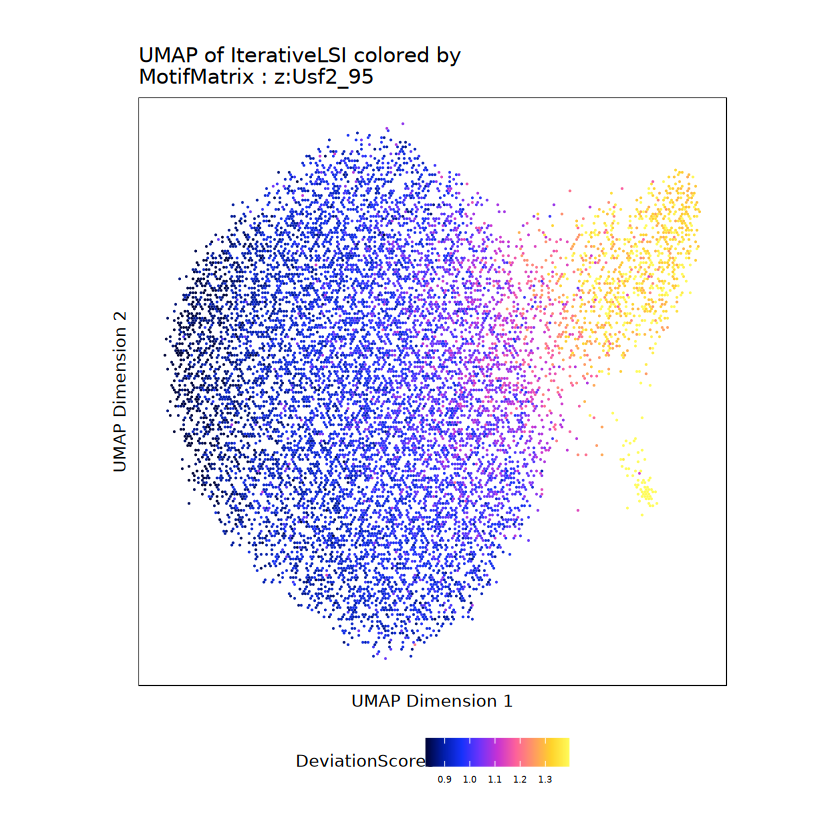

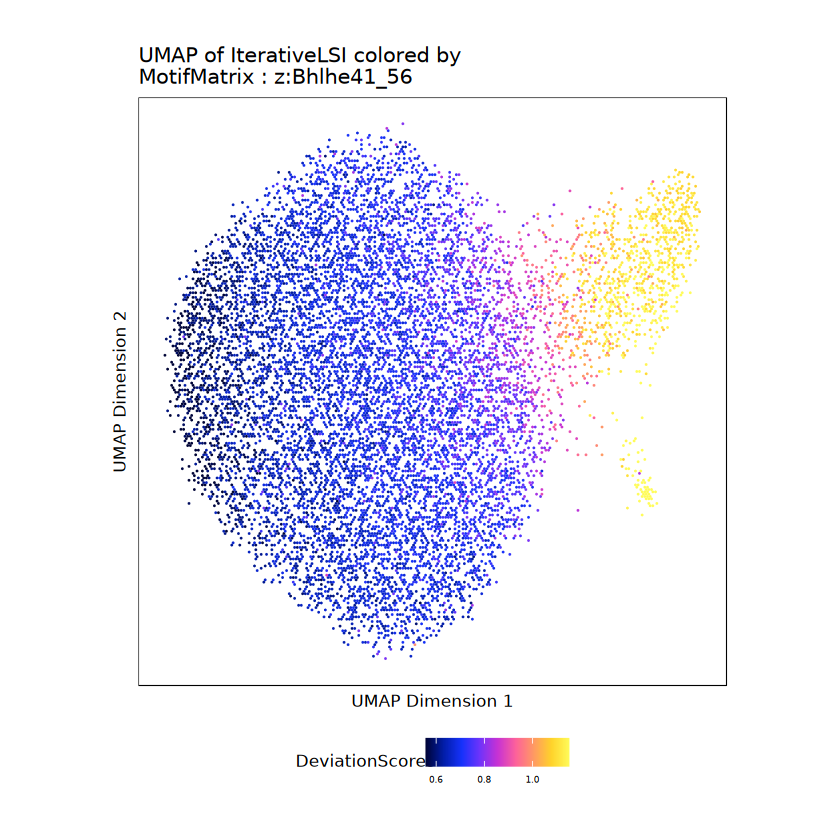

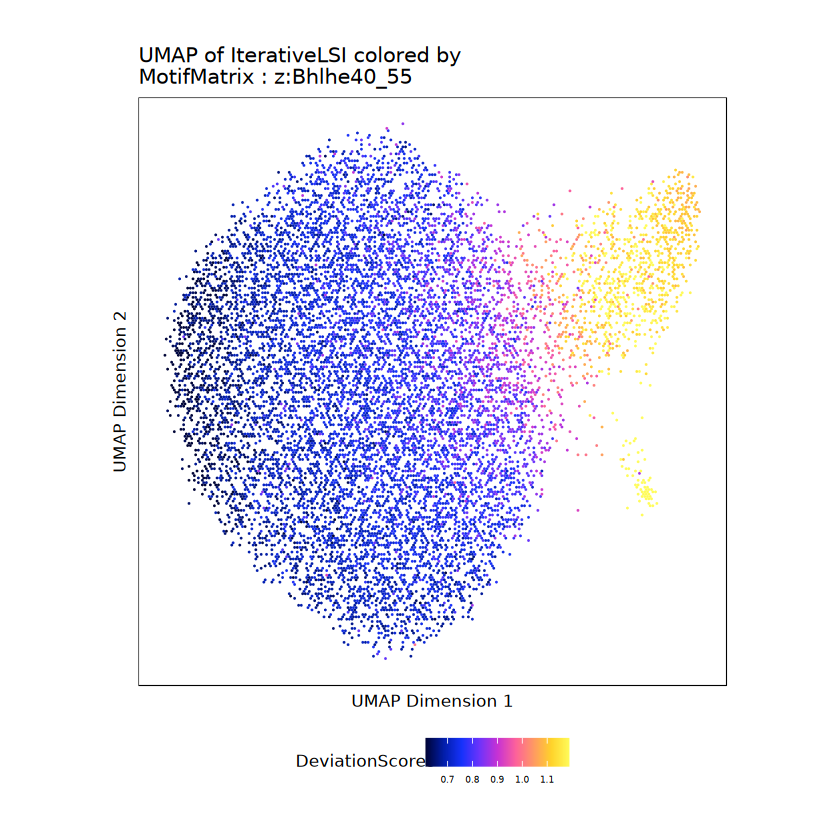

$`z:Usf2_95`

$`z:Bhlhe41_56`

$`z:Bhlhe40_55`

$`z:Egr1_190`

$`z:Atf3_110`


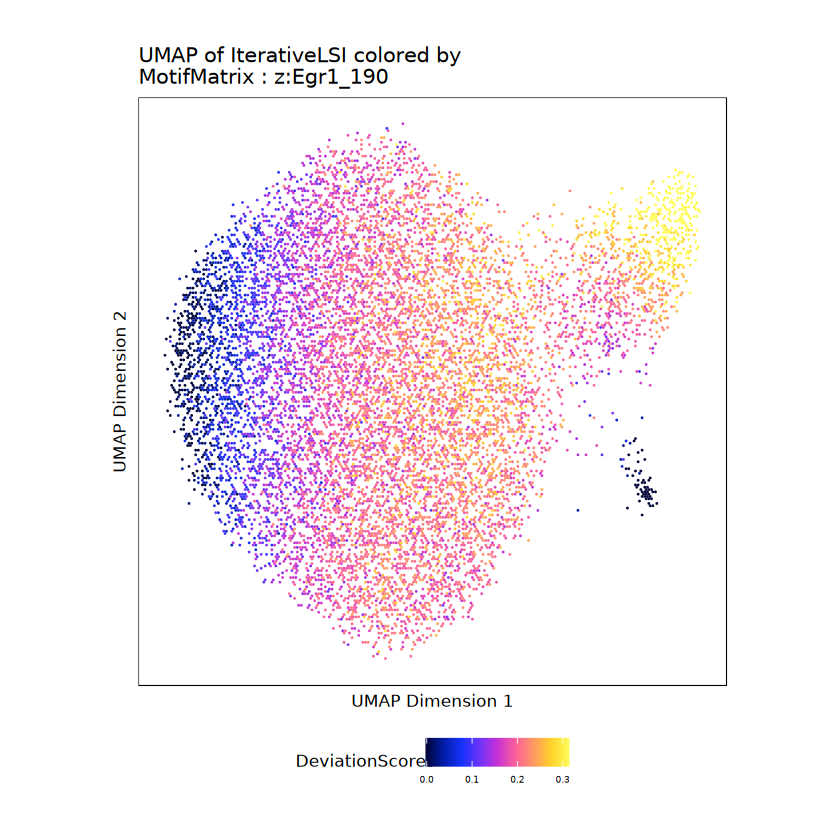

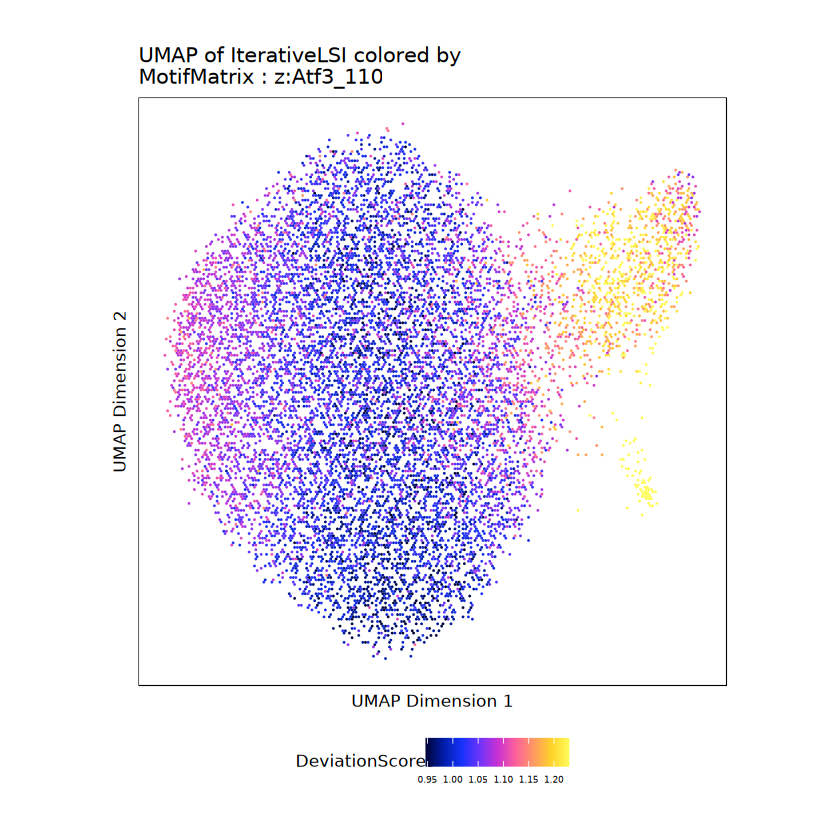

In [225]:
T3_TFsU <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "MotifMatrix", 
    name = T3_TFs, 
    embedding = "UMAP",
    continuousSet = "horizonExtra",
    imputeWeights = getImputeWeights(proj)
)
T3_TFsU

In [226]:
proj_zscores <- getMatrixFromProject(proj, useMatrix = 'MotifMatrix')
scores <- as.matrix(assay(proj_zscores))
celldata <- as.data.frame(colData(proj_zscores))
motifdata <- as.data.frame(rowData(proj_zscores))
all_motifs <- motifdata$name 
names(all_motifs) <- motifdata$idx

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-167de33a41ae30-Date-2025-01-27_Time-13-19-36.957765.log
If there is an issue, please report to github with logFile!

2025-01-27 13:19:42.004128 : Organizing colData, 0.084 mins elapsed.

2025-01-27 13:19:42.148318 : Organizing rowData, 0.087 mins elapsed.

2025-01-27 13:19:42.152123 : Organizing rowRanges, 0.087 mins elapsed.

2025-01-27 13:19:42.157486 : Organizing Assays (1 of 2), 0.087 mins elapsed.

2025-01-27 13:19:42.232231 : Organizing Assays (2 of 2), 0.088 mins elapsed.

2025-01-27 13:19:42.341296 : Constructing SummarizedExperiment, 0.09 mins elapsed.

2025-01-27 13:19:43.102131 : Finished Matrix Creation, 0.102 mins elapsed.



In [227]:
T3_motifs <- c('Usf2_95','Bhlhe41_56','Bhlhe40_55','Egr1_190','Atf3_110')

In [140]:
idx_T3 <- which(all_motifs %in% T3_motifs)
T3_sig_scores <- scores[c(idx_T3),] %>% colSums()
T3_sig_scores_avg <- T3_sig_scores/length(idx_T3)
proj <- addCellColData(ArchRProj = proj, data = T3_sig_scores_avg, cells = names(T3_sig_scores_avg), name = "T3_motifs_zscores")

In [141]:
proj <- saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-167de3558dcdfe-Date-2025-01-27_Time-13-19-43.198096.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Imputing Matrix

Using weights on disk

1 of 2

2 of 2

Using weights on disk

1 of 2

2 of 2

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-167de3558dcdfe-Date-2025-01-27_Time-13-19-43.198096.log



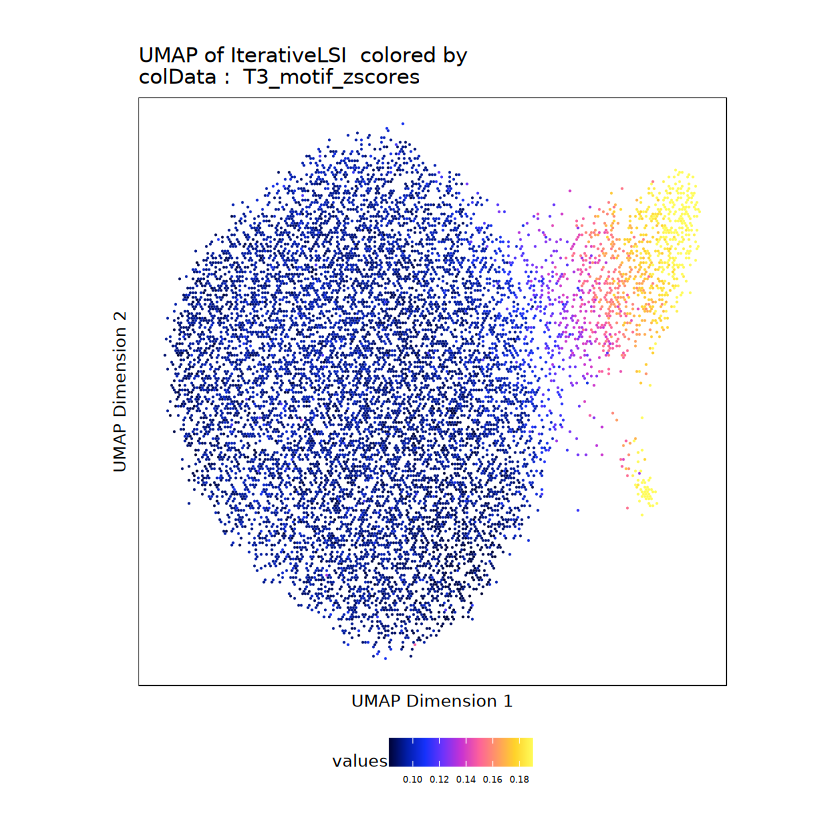

In [228]:
T3_motifsU <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = 'T3_motif_zscores',
    embedding = "UMAP",
    continuousSet = "horizonExtra",
    imputeWeights = getImputeWeights(proj)
)
T3_motifsU

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-167de343a8ba3c-Date-2025-01-23_Time-12-40-55.727981.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
2 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-167de343a8ba3c-Date-2025-01-23_Time-12-40-55.727981.log



$Neutrophil_subtype

$Treatment


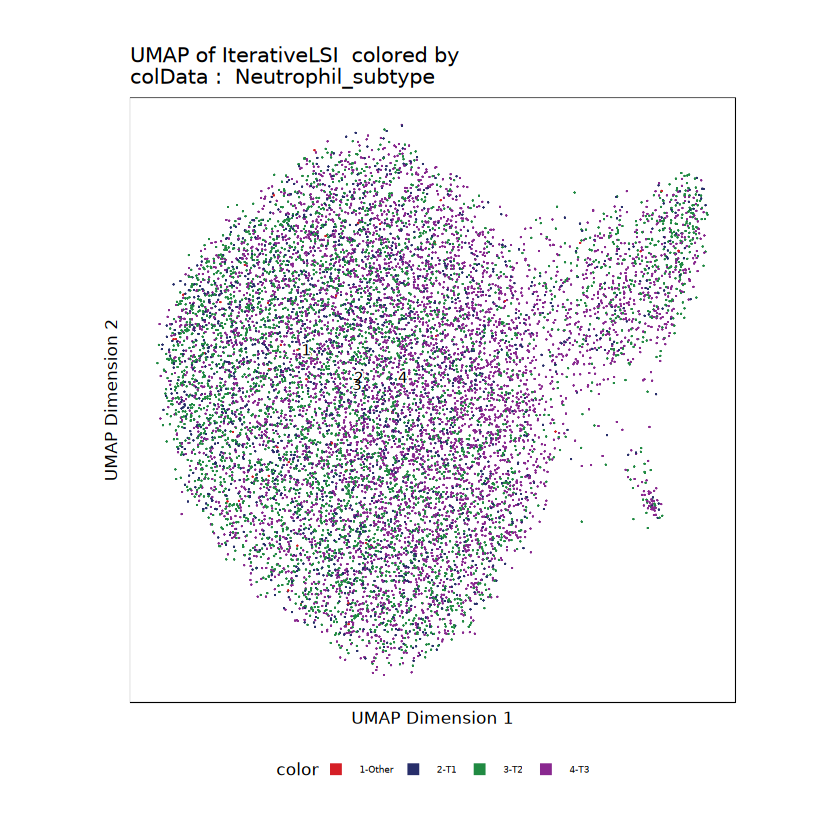

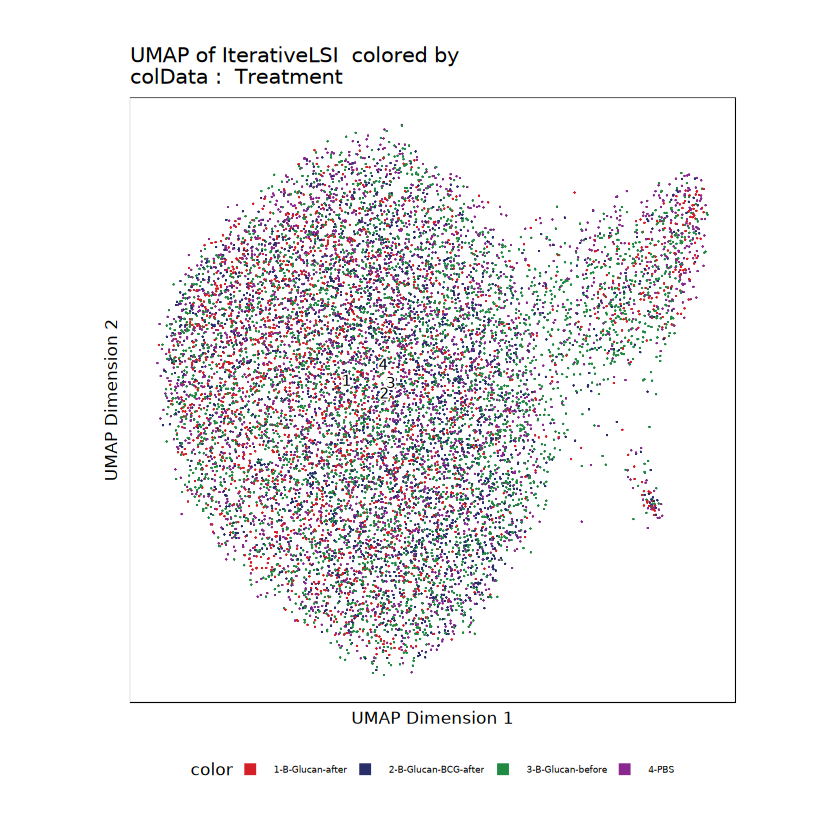

In [149]:
treatment_U <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = c('Neutrophil_subtype','Treatment'),
    embedding = "UMAP",
    continuousSet = "horizonExtra"
)
treatment_U

In [158]:
pdf(file.path(outs_dir,"02_neutrophils_T3_plots.pdf"),width = 16, height = 15)
#pdf("merged_archr_qcmetrics_Bladder.pdf", width = 15, height = 15)
#grid.table(top10genespercluster, theme = ttheme_minimal(base_size = 10))
grid.arrange(do.call(gridExtra::arrangeGrob, c(T3_TFsU, ncol = 3)))
T3_motifsU
grid.arrange(do.call(gridExtra::arrangeGrob, c(treatment_U, ncol = 2)))
#grid.arrange(c1, c2, c3, ncol = 2)
dev.off()

pdf 
  2

# Density Plot

In [3]:
library(ArchR)
library(dplyr)
library(Seurat)
library(Cairo)
library(ggplot2)
library(Matrix)
library(hexbin)
library(gridExtra)
#library(Signac)
library(tidyverse)
library(reshape2)
library(readxl)
library(pheatmap)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggplot2)
library(ggpubr)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




In [230]:
current_dir <- getwd()
Archr_Dir <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder'
proj_name <- 'Neutrophils'
setwd(Archr_Dir)

In [231]:
proj <- loadArchRProject(file.path(Archr_Dir,proj_name))
archr_metadata <- as.data.frame(getCellColData(proj))
proj

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

class: ArchRProject 
outputDirectory: /athena/cayuga_0039/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder/Neutrophils 
samples(4): MAZ6 MAZ5 MAZ7 MAZ8
sampleColData names(1): ArrowFiles
cellColData names(37): Sample TSSEnrichment ... T3_motif_zscores
  T3_motifs_zscores
numberOfCells(1): 11779
medianTSS(1): 27.133
medianFrags(1): 2378

In [232]:
umap_coords <- getEmbedding(proj, embedding = "UMAP")
metadata <- merge(archr_metadata, umap_coords, by = "row.names", all = TRUE)
colnames(metadata)[colnames(metadata) == "IterativeLSI#UMAP_Dimension_1"] <- "UMAP1"
colnames(metadata)[colnames(metadata) == "IterativeLSI#UMAP_Dimension_2"] <- "UMAP2"
head(metadata)

Row.names               Sample TSSEnrichment ReadsInTSS ReadsInPromoter
1 MAZ5#AAACAAGCAAGCTCAA-1 MAZ5   39.518         459       1617           
2 MAZ5#AAACAAGCAGGACCTG-1 MAZ5   32.178         325       1100           
3 MAZ5#AAACAAGCAGGATCAC-1 MAZ5   32.718         727       2345           
4 MAZ5#AAACCGCCAGGTGAGA-1 MAZ5   23.673        1064       3296           
5 MAZ5#AAACCGCCATGAAGCC-1 MAZ5   51.089         645       2044           
6 MAZ5#AAACGAACAGGTAAGG-1 MAZ5   24.337         381       1274           
  ReadsInBlacklist PromoterRatio PassQC NucleosomeRatio nMultiFrags ⋯
1  96              0.4244094     1      0.4486692        79         ⋯
2  76              0.4320503     1      0.4433107        43         ⋯
3 134              0.4122714     1      0.5135710        89         ⋯
4 212              0.4227809     1      0.5910204       136         ⋯
5 152              0.4303158     1      0.5759788        78         ⋯
6 115              0.3697040     1      0.5370205        55         ⋯
  T2_gene_scores T3_gene_scores Neutrophil_subtype T1_normalized T2_normalized
1 2.606857       1.63515        T3                 0.00000000    0.13318007   
2 2.849214       2.37100        T3                 0.00000000    0.14556170   
3 3.516357       1.27975        T2                 0.10226112    0.17964494   
4 1.539214       1.81970        T3                 0.07423810    0.07863594   
5 3.002071       3.20450        T3                 0.01850703    0.15337092   
6 8.640500       1.60635        T2                 0.02412881    0.44142901   
  T3_normalized T3_motif_zscores T3_motifs_zscores UMAP1      UMAP2      
1 0.1406780     -0.03352793      -0.03352793       -2.3980877  1.17709705
2 0.2039859      0.01298079       0.01298079        2.4458001 -0.08241085
3 0.1101016      0.01058601       0.01058601        0.6387557  1.65413483
4 0.1565556      0.14423671       0.14423671        0.7663106  1.08516868
5 0.2756950      0.12888089       0.12888089       -1.1174696  1.43691715
6 0.1382003      0.18295723       0.18295723        5.5173698  0.94335445

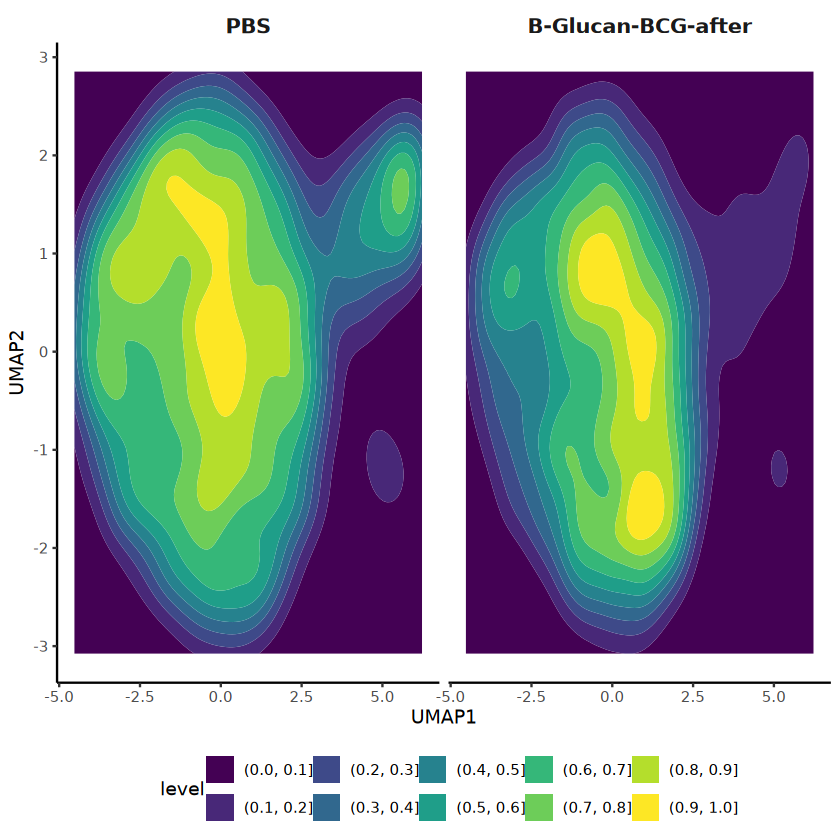

In [242]:
# Subset the metadata to include only the two treatments you want
metadata_sub <- metadata[metadata$Treatment %in% c("PBS", "B-Glucan-BCG-after"), ]

# Reorder the 'Treatment' factor if you want a custom order
metadata_sub$Treatment <- factor(metadata_sub$Treatment, levels = c("PBS", "B-Glucan-BCG-after"))

# Plot for only the two treatments
p4 <- ggplot(metadata_sub, aes(x = UMAP1, y = UMAP2)) +
  geom_density_2d_filled(contour_var = "ndensity") +
  facet_wrap(vars(Treatment)) +  # Facet by 'Treatment' with new order
  theme_classic() +
  theme(
    legend.position = "bottom",  # Move legend to the bottom
    strip.background = element_blank(),  # Remove facet label background
    strip.text = element_text(size = 12, face = "bold")  # Bold facet labels
  )

p4

# All celltypes

In [4]:
current_dir <- getwd()
Archr_Dir <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder'
proj_name <- 'manually_filtered2'
setwd(Archr_Dir)

In [5]:
proj <- loadArchRProject(file.path(Archr_Dir,proj_name))
archr_metadata <- as.data.frame(getCellColData(proj))
proj

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

class: ArchRProject 
outputDirectory: /athena/cayuga_0039/scratch/rer4011/projects/MAZ_andrew_data/intermediate_results/merged_ArchR_Bladder/manually_filtered2 
samples(4): MAZ6 MAZ5 MAZ7 MAZ8
sampleColData names(1): ArrowFiles
cellColData names(28): Sample TSSEnrichment ... Treatment Sample2
numberOfCells(1): 37276
medianTSS(1): 24.4875
medianFrags(1): 3914

In [8]:
proj_zscores <- getMatrixFromProject(proj, useMatrix = 'MotifMatrix')
scores <- as.matrix(assay(proj_zscores))
celldata <- as.data.frame(colData(proj_zscores))
motifdata <- as.data.frame(rowData(proj_zscores))
all_motifs <- motifdata$name 
names(all_motifs) <- motifdata$idx

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-e19e33cdb321-Date-2025-01-29_Time-12-50-03.590614.log
If there is an issue, please report to github with logFile!

2025-01-29 12:50:49.70837 : Organizing colData, 0.769 mins elapsed.

2025-01-29 12:50:49.878672 : Organizing rowData, 0.771 mins elapsed.

2025-01-29 12:50:49.884996 : Organizing rowRanges, 0.772 mins elapsed.

2025-01-29 12:50:49.89465 : Organizing Assays (1 of 2), 0.772 mins elapsed.

2025-01-29 12:50:51.289058 : Organizing Assays (2 of 2), 0.795 mins elapsed.

2025-01-29 12:50:52.632291 : Constructing SummarizedExperiment, 0.817 mins elapsed.

2025-01-29 12:50:53.596955 : Finished Matrix Creation, 0.833 mins elapsed.



In [9]:
T3_motifs <- c('Usf2_95','Bhlhe41_56','Bhlhe40_55','Egr1_190','Atf3_110')

In [13]:
idx_T3 <- which(all_motifs %in% T3_motifs)
T3_sig_scores <- scores[c(idx_T3),] %>% colSums()
T3_sig_scores_avg <- T3_sig_scores/length(idx_T3)
proj <- addCellColData(ArchRProj = proj, data = T3_sig_scores_avg, cells = names(T3_sig_scores_avg), name = "T3_motifs_zscores")

ERROR: Error in addCellColData(ArchRProj = proj, data = T3_sig_scores_avg, cells = names(T3_sig_scores_avg), : Error previous entry for T3_motifs_zscores, Set force = TRUE to override!


Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-e19e60a05d2d-Date-2025-01-29_Time-12-54-12.966932.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-e19e60a05d2d-Date-2025-01-29_Time-12-54-12.966932.log



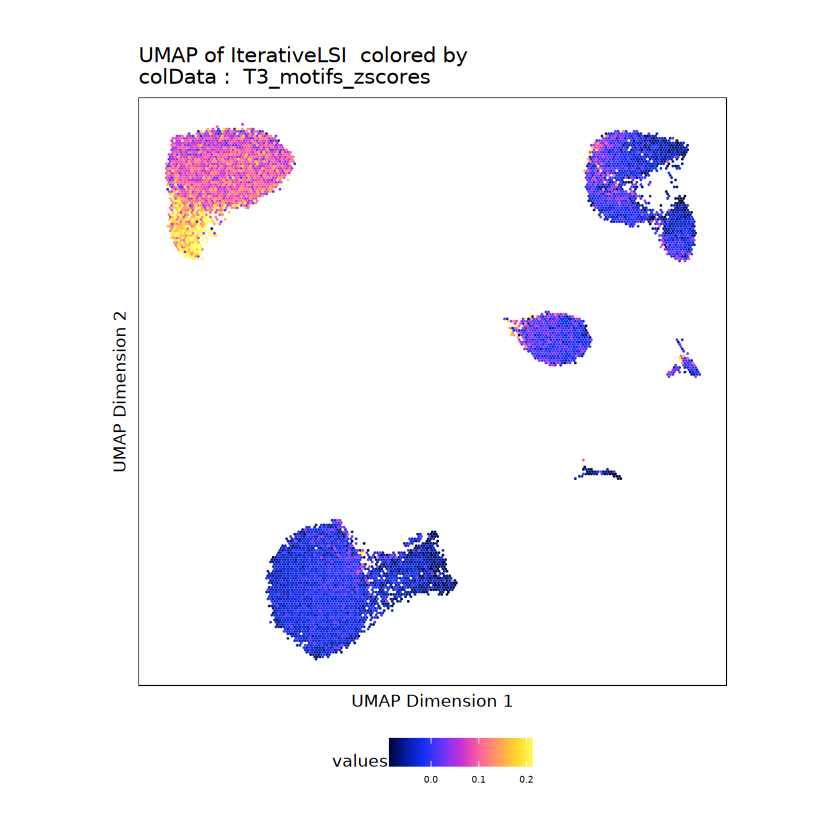

In [15]:
T3_motifsU2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = 'T3_motifs_zscores',
    embedding = "UMAP",
    continuousSet = "horizonExtra",
    imputeWeights = getImputeWeights(proj)
)
T3_motifsU2

In [16]:
umap_coords <- getEmbedding(proj, embedding = "UMAP")
metadata <- merge(archr_metadata, umap_coords, by = "row.names", all = TRUE)
colnames(metadata)[colnames(metadata) == "IterativeLSI#UMAP_Dimension_1"] <- "UMAP1"
colnames(metadata)[colnames(metadata) == "IterativeLSI#UMAP_Dimension_2"] <- "UMAP2"
head(metadata)

Row.names               Sample TSSEnrichment ReadsInTSS ReadsInPromoter
1 MAZ5#AAACAAGCAACGGTGT-1 MAZ5   16.895         401       1407           
2 MAZ5#AAACAAGCAAGCTCAA-1 MAZ5   39.518         459       1617           
3 MAZ5#AAACAAGCAAGGCCAT-1 MAZ5   17.955        1614       5530           
4 MAZ5#AAACAAGCAATCTCTA-1 MAZ5   28.796        1556       4968           
5 MAZ5#AAACAAGCACCATGCC-1 MAZ5   17.929         833       3010           
6 MAZ5#AAACAAGCAGGACCTG-1 MAZ5   32.178         325       1100           
  ReadsInBlacklist PromoterRatio PassQC NucleosomeRatio nMultiFrags ⋯
1  68              0.3126667     1      0.4610390        69         ⋯
2  96              0.4244094     1      0.4486692        79         ⋯
3 415              0.3093187     1      0.5594906       367         ⋯
4 396              0.3639027     1      0.7185297       353         ⋯
5 208              0.2842304     1      0.5716830       243         ⋯
6  76              0.4320503     1      0.4433107        43         ⋯
  predictedScore_Un predictedCell                                         
1 1.0000000         AGTTGGTCAGATGGGT-1#Sample_Wt_BCG_BL_IGO_15872_1__count
2 0.6110129         GCCAAATAGATCCGAG-1#Sample_Wt_BCG_BL_IGO_15872_1__count
3 0.9280223         CTCGTACGTAGAGTGC-1#Sample_Wt_PBS_BL_IGO_15872_2__count
4 1.0000000         GACACGCCATGATCCA-1#Sample_Wt_PBS_BL_IGO_15872_2__count
5 0.9853703         GTCACGGGTTATCGGT-1#Sample_Wt_PBS_BL_IGO_15872_2__count
6 0.6580309         AAAGATGAGAAGGACA-1#Sample_Wt_BCG_BL_IGO_15872_1__count
  predictedGroup predictedScore filteration_status Cell_Annotation1     
1 Monocytes      0.9696137      present            Monocytes/Macrophages
2 Neutrophils    0.6520593      present            Neutrophils          
3 Monocytes      0.6648381      present            Monocytes/Macrophages
4 Tcells         1.0000000      present            CD4T                 
5 Monocytes      0.9925705      present            Monocytes/Macrophages
6 Neutrophils    0.8815217      present            Neutrophils          
  Treatment Sample2 UMAP1     UMAP2     
1 PBS       PBS     -2.000646  -9.095336
2 PBS       PBS     -5.390832   8.204631
3 PBS       PBS     -4.173546  -9.365069
4 PBS       PBS     10.736904   9.570154
5 PBS       PBS     -2.042801 -10.806290
6 PBS       PBS     -8.547234   8.019420

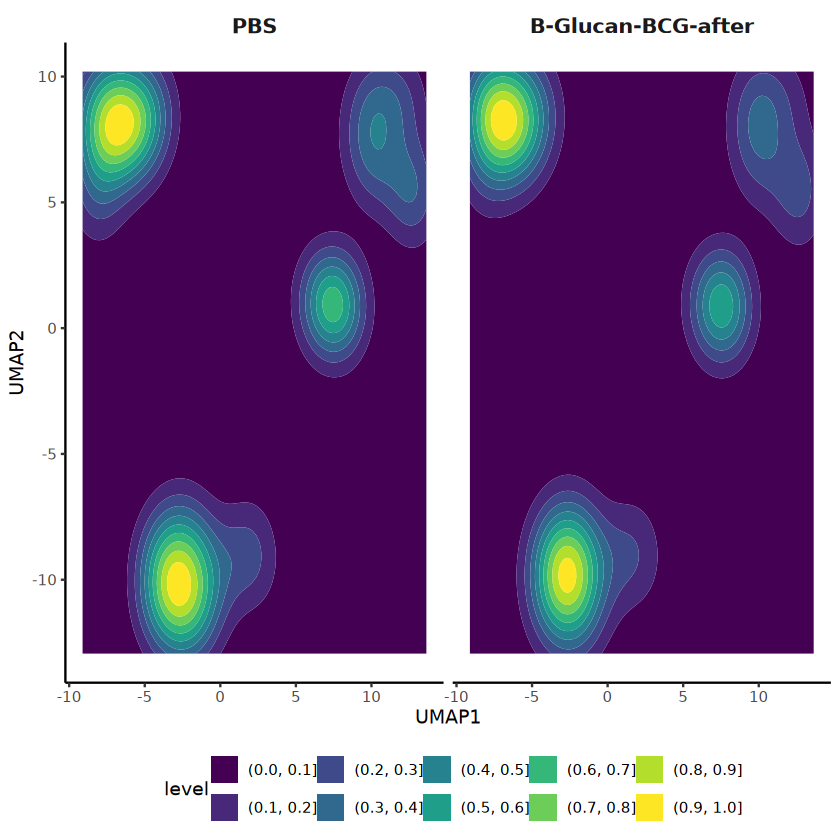

In [20]:
# Subset the metadata to include only the two treatments you want
metadata_sub <- metadata[metadata$Treatment %in% c("PBS", "B-Glucan-BCG-after"), ]

# Reorder the 'Treatment' factor if you want a custom order
metadata_sub$Treatment <- factor(metadata_sub$Treatment, levels = c("PBS", "B-Glucan-BCG-after"))

# Plot for only the two treatments
p5 <- ggplot(metadata_sub, aes(x = UMAP1, y = UMAP2)) +
  geom_density_2d_filled(contour_var = "ndensity") +
  facet_wrap(vars(Treatment)) +  # Facet by 'Treatment' with new order
  theme_classic() +
  theme(
    legend.position = "bottom",  # Move legend to the bottom
    strip.background = element_blank(),  # Remove facet label background
    strip.text = element_text(size = 12, face = "bold")  # Bold facet labels
  )

p5

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-167de320e421c4-Date-2025-01-27_Time-13-17-12.729466.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
2 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-167de320e421c4-Date-2025-01-27_Time-13-17-12.729466.log



$Treatment

$Cell_Annotation1


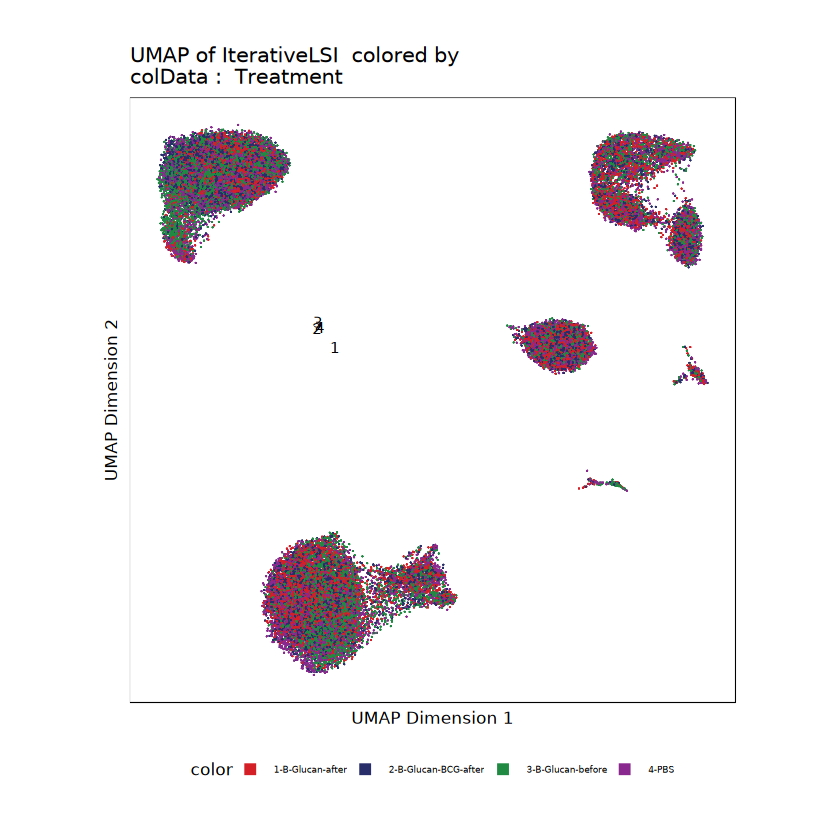

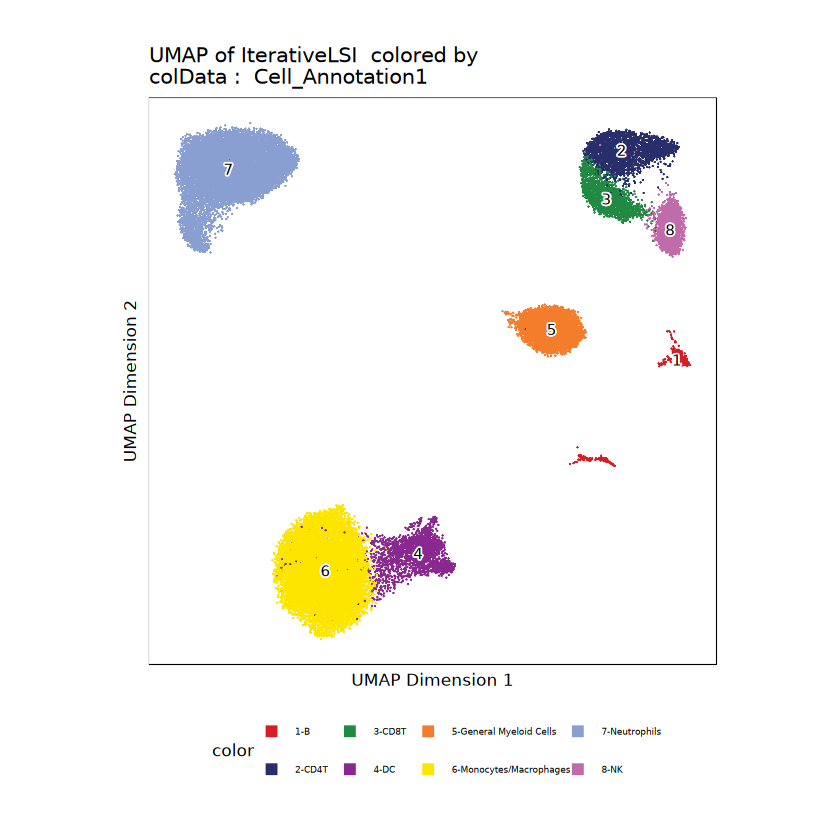

In [218]:
plotEmbedding(
  ArchRProj = proj,
  embedding = "UMAP",
  colorBy = "cellColData",
  name = c("Treatment","Cell_Annotation1"))

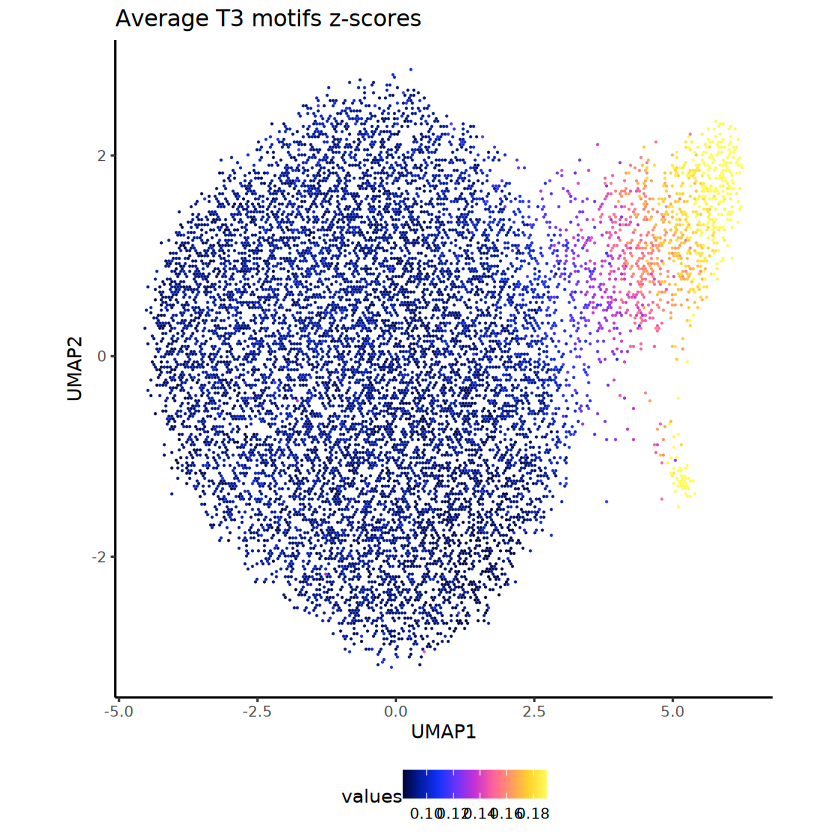

In [239]:
p3 <- T3_motifsU + theme_classic() +
  labs(title = "Average T3 motifs z-scores", 
       x = "UMAP1", y = "UMAP2") +
  theme(
    legend.position = "bottom",  # Move legend to the bottom
    strip.background = element_blank(),  # Remove facet label background
    strip.text = element_text(size = 12, face = "bold")  # Bold facet labels
  )
p3

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

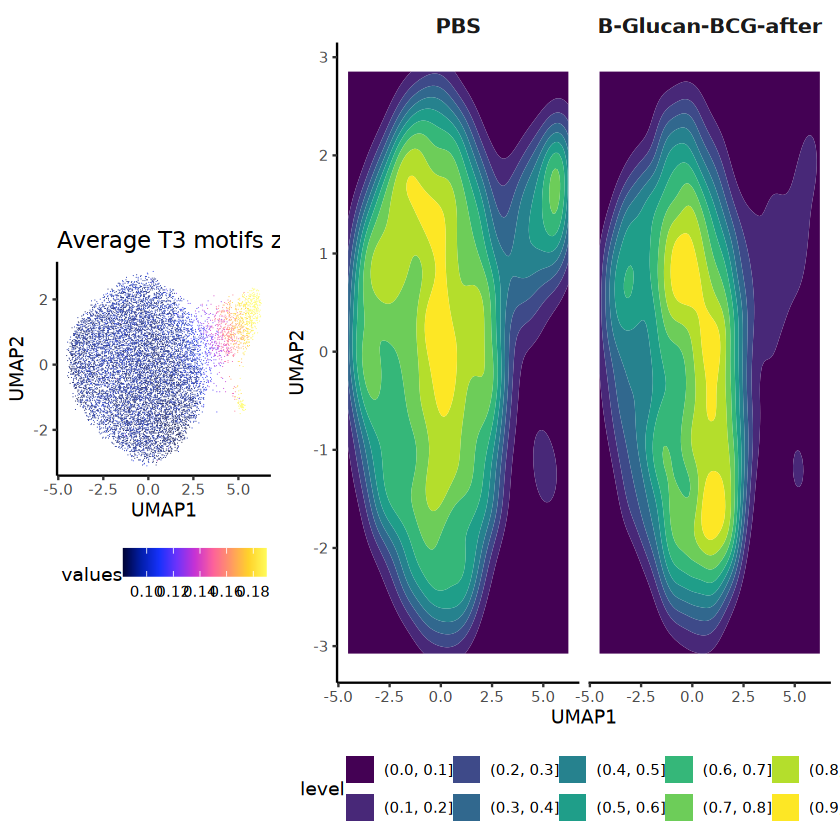

In [240]:
combined_plot <- grid.arrange(p3, p4, ncol = 2, widths = c(1, 2))  # p3 is 1x, p4 is 2x wider
combined_plot
# Save the combined plot as a JPG file
ggsave("combined_plot.jpg", plot = combined_plot, width = 16, height = 6, dpi = 300)